Activity 1
Analog IC Characterization: The Wideband RC Voltage-Divider

I. INTRODUCTION

The frequency-independent signal attenuator is a fundamental building block in high-bandwidth analog measurement systems, where accurate signal scaling must be maintained over a wide range of frequencies. Simple resistive voltage dividers, while effective at low frequencies, often exhibit frequency-dependent behavior when parasitic capacitances and source or load impedances are introduced. These effects become especially pronounced in wideband applications, leading to signal distortion, amplitude errors, and phase shift.

To address these limitations, RC compensation techniques are employed. By intentionally adding capacitive elements in parallel with resistive components, the frequency response of the divider can be shaped to achieve flat attenuation across a broad spectrum. This principle is widely used in practical instrumentation such as oscilloscope probes, data acquisition front-ends, and analog integrated circuits, where maintaining signal integrity is critical.

This laboratory activity examines the wideband RC voltage divider as a representative analog IC building block. Students will explore the theoretical basis of RC compensation, including pole-zero cancellation and time-constant matching, and observe how these concepts translate into real circuit behavior. Emphasis is placed on understanding how component values influence bandwidth, transient response, and overall signal fidelity.

In addition to theory, the laboratory integrates circuit simulation using NGSPICE within a Visual Studio Code (VS Code) workflow. This environment mirrors modern engineering practice by combining schematic-level analysis with script-based simulation and waveform inspection. Through simulation, students will characterize both uncompensated and compensated dividers in the time and frequency domains, reinforcing the connection between mathematical models and observable circuit performance.

II. MATERIALS AND EQUIPMENT

Computing Workstation (PC or Laptop)

Integrated Development Environment (IDE): Visual Studio Code

NGSPICE Simulator: (Version 42+)

Python 3.x (pandas, matplotlib, numpy, schemdraw)

III. PROCEDURES

PHASE 1: INSTALLATION & SYSTEM CONFIGURATION

Step 1: Install NGSPICE (The Simulator)

    Download ngspice-42_64.zip from the NGSPICE SourceForge page.

    Extract the file and copy the Spice64 folder.

    Paste it directly into the C: drive:

            C:\Spice64
    
    Verify that ngspice.exe exists in:

            C:\Spice64\bin

Step 2: Add NGSPICE to Windows PATH

    Copy Path:

        C:\Spice64\bin

    Open Edit the system environment variables.

    Under System variables → Path → Edit → New, paste the path.

    Click OK to save.

Step 3: Verify in VS Code

    Restart VS Code.

    Open the terminal (Ctrl + `).

    Run:

        ngspice -v
    
    The NGSPICE version output confirms successful installation.

PHASE 2: PYTHON ENVIRONMENT SETUP
Install Required Python Libraries

Purpose:
These libraries will be used for circuit visualization (schemdraw), data handling (pandas), numerical analysis (numpy), and plotting simulation results (matplotlib).

In [1]:
pip install schemdraw pandas matplotlib numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Verify NGSPICE Availability

Purpose:
Confirms that NGSPICE is correctly installed and accessible from the Jupyter Notebook environment before running simulations.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import os

# Robust verification: This checks if NGSPICE is accessible
try:
    result = subprocess.run(["ngspice", "-v"], capture_output=True, text=True)
    if result.stdout:
        # Print the first available line of the version info
        print(f"NGSPICE Found: {result.stdout.splitlines()[0]}")
    else:
        print("NGSPICE executed but returned no version text.")
except FileNotFoundError:
    print("ERROR: NGSPICE not found. Please check your Windows PATH and restart VS Code.")

NGSPICE executed but returned no version text.


PHASE 3: CIRCUIT SCHEMATIC VISUALIZATION
Draw RC Divider Circuit

Purpose:
This cell visualizes the wideband RC voltage divider, showing:
    R1 with compensation capacitor C1
    Load resistor R2 and load capacitor C2
    Input Vin and output Vout nodes

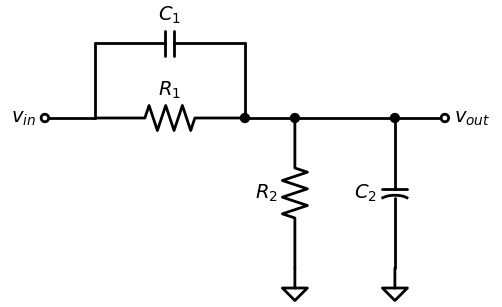

In [34]:
import schemdraw
import schemdraw.elements as elm

with schemdraw.Drawing() as d:
    d += (vin := elm.Dot(open=True).label('$v_{in}$', loc='left'))
    d += elm.Line().right().length(1)
    d.push()
    d += elm.Resistor().label('$R_1$')
    d.pop()
    d += elm.Line().up().length(1.5)
    d += elm.Capacitor().right().label('$C_1$')
    d += elm.Line().down().length(1.5)
    d += elm.Dot()
    d += elm.Line().right().length(1)
    d.push()
    d += elm.Resistor().down().label('$R_2$')
    d += elm.GroundSignal()
    d.pop()
    d += elm.Dot()
    d += elm.Line().right().length(2)
    d.push()
    d += elm.Capacitor2().down().label('$C_2$')
    d += elm.GroundSignal()
    d.pop()
    d += elm.Dot()
    d += elm.Line().right().length(1)
    d += elm.Dot(open=True).label('$v_{out}$', loc='right')

PHASE 4: NGSPICE NETLIST GENERATION & SIMULATION
Generate Netlist, Run Simulation, and Verify Output

Purpose:
    Generates a complete NGSPICE netlist using Python-defined component values.
    Runs AC and transient analyses in batch mode.
    Verifies that data files (output_ac.dat, output_tran.dat) are created for further plotting and analysis.

In [42]:
spice_netlist = """* Wideband RC Voltage Divider
.options savecurrents

* Main Circuit
R1 in out 18k
R2 out 0 2.7k
C1 in out 7.0500p
C2 out 0 47.000p

* Variations
R1a in outa 900k
R2a outa 0 100k
C1a in outa 1.6p
C2a outa 0 10p

R1b in outb 900k
R2b outb 0 100k
C1b in outb 0.7p
C2b outb 0 10p

V1 in 0 pulse(-0.1 0.1 0 0.1u 0.1u 5u 10u) dc 1 ac 1

.control
  ac dec 10 1 1G
  wrdata output_ac.dat v(out) v(outa) v(outb)
  
  tran 0.01u 30u
  wrdata output_tran.dat v(out) v(outa) v(outb)
  quit
.endc
.end
"""

with open("netlist.spice", "w") as f:
    f.write(spice_netlist)
print("netlist.spice created.")

netlist.spice created.


RUN SIMULATION WITH FILE CLEANUP
Ensure Fresh Simulation and Verify Output

Purpose:

    Ensures old simulation files are removed before running a new simulation.
    Runs NGSPICE in batch mode and verifies that AC and transient data files are generated.
    Provides immediate feedback if something goes wrong.

In [43]:
import subprocess
import os

# Remove old files to be sure we are seeing new results
for f in ["output_ac.dat", "output_tran.dat"]:
    if os.path.exists(f):
        os.remove(f)

try:
    # Running in batch mode
    subprocess.run(["ngspice", "-b", "netlist.spice"], check=True)
    
    if os.path.exists("output_tran.dat"):
        print("Success! Simulation finished and data files are ready.")
    else:
        print("Simulation finished but no data files were found.")
except subprocess.CalledProcessError as e:
    print(f"Simulation failed with error code {e.returncode}")

Success! Simulation finished and data files are ready.


PHASE 5: PLOT TRANSIENT RESPONSE
    Read and Plot Transient Data

Data detected: 6 columns


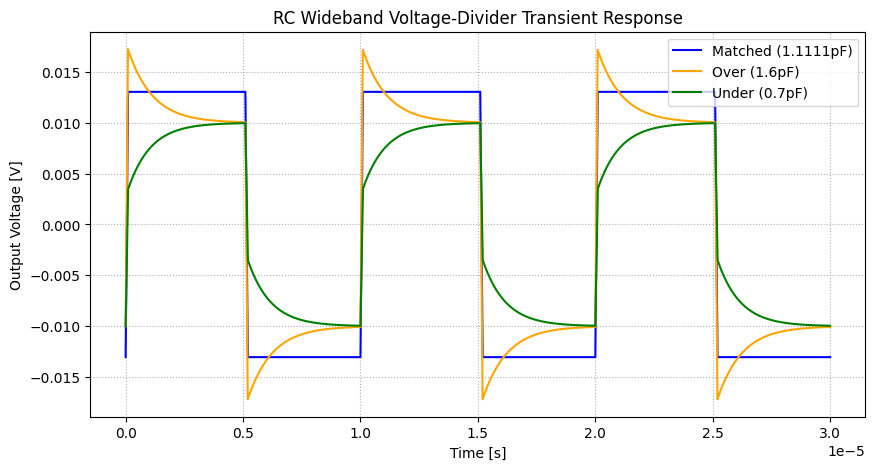

In [44]:
# Read the file without specifying columns first
df_tran = pd.read_csv("output_tran.dat", sep='\\s+', header=None)

# Let's check the shape to be safe
print(f"Data detected: {df_tran.shape[1]} columns")

# NGSPICE often exports: Time, Vout, Time, VoutA, Time, VoutB
# We only need the first Time and the Voltages
if df_tran.shape[1] == 6:
    df_tran.columns = ["time", "vout", "time2", "vouta", "time3", "voutb"]
elif df_tran.shape[1] == 4:
    df_tran.columns = ["time", "vout", "vouta", "voutb"]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_tran['time'], df_tran['vout'], label="Matched (1.1111pF)", color='blue')
plt.plot(df_tran['time'], df_tran['vouta'], label="Over (1.6pF)", color='orange')
plt.plot(df_tran['time'], df_tran['voutb'], label="Under (0.7pF)", color='green')

plt.title("RC Wideband Voltage-Divider Transient Response")
plt.xlabel("Time [s]")
plt.ylabel("Output Voltage [V]")
plt.legend(loc='upper right')
plt.grid(True, linestyle='dotted')
plt.show()

PHASE 6: READ FREQUENCY RESPONSE DATA
Read AC Simulation Output

Purpose:
    Loads NGSPICE AC simulation results into a pandas DataFrame.
    Handles multiple output nodes and varying file formats.
    Prepares the data for plotting frequency-domain response in the next cell.

In [45]:
# @title Read in SPICE frequency response data
df_ac = pd.read_csv("output_ac.dat", sep='\\s+', header=None)

# Handle the 9-column format (Frequency repeated for each node)
if df_ac.shape[1] == 9:
    df_ac.columns = [
        "freq", "vout_re", "vout_im", 
        "freq2", "vouta_re", "vouta_im", 
        "freq3", "voutb_re", "voutb_im"
    ]
elif df_ac.shape[1] == 7:
    df_ac.columns = ["freq", "vout_re", "vout_im", "vouta_re", "vouta_im", "voutb_re", "voutb_im"]

df_ac.head()

,freq,vout_re,vout_im,freq2,vouta_re,vouta_im,freq3,voutb_re,voutb_im
0,1.000000,0.130435,-1.323489e-23,1.000000,0.1,2.488141e-07,1.000000,0.1,-2.092301e-07
1,1.258925,0.130435,-2.646978e-23,1.258925,0.1,3.132384e-07,1.258925,0.1,-2.634051e-07
2,1.584893,0.130435,-7.940934e-23,1.584893,0.1,3.943438e-07,1.584893,0.1,-3.316073e-07
3,1.995262,0.130435,-2.646978e-23,1.995262,0.1,4.964495e-07,1.995262,0.1,-4.174689e-07
4,2.511886,0.130435,-5.293956e-23,2.511886,0.1,6.249929e-07,2.511886,0.1,-5.255622e-07


PHASE 7: CALCULATE AC MAGNITUDE AND PHASE
Compute Magnitude and Phase from NGSPICE AC Data

Purpose:
    Converts NGSPICE output (real + imaginary) into magnitude and phase for each output node.
    Prepares data for frequency-domain plotting to analyze bandwidth and compensation performance.

In [46]:
# @title Calculate the magnitude and phase of the output voltage
# Note: NGSPICE writes the real and imaginary components of the voltage

# Collect all real components in a list
v_real = [ df_ac['vout_re'], df_ac['vouta_re'], df_ac['voutb_re'] ]

# Collect all imaginary components in a list
v_imag = [ df_ac['vout_im'], df_ac['vouta_im'], df_ac['voutb_im'] ]

# Iterate over the lists to get the magnitude and phase of the voltages
v_mag = [ np.sqrt(vr**2 + vi**2) for vr,vi in zip(v_real, v_imag) ]
v_phase = [ np.arctan2(vi, vr) * 180 / np.pi for vr,vi in zip(v_real, v_imag) ]

PHASE 8: PLOT AC MAGNITUDE RESPONSE
Frequency Response (Magnitude in dB)

Purpose:
    Converts voltage magnitudes to dB and plots them on a logarithmic frequency scale.
    Compares matched, over-, and under-compensation to illustrate the effect of C1 on bandwidth.
    Helps students visualize how RC compensation flattens the frequency response.

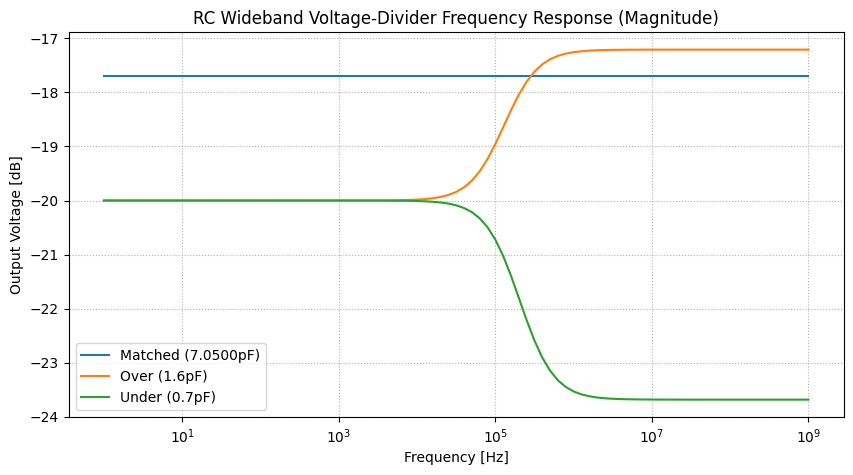

In [47]:
# @title Plot the magnitude frequency response of the wideband RC voltage-divider

# Define labels locally to reflect the Seed-based values
# C1_matched was calculated in Cell 1
 
v_label = [f"Matched ({C1_matched:.4f}pF)", "Over (1.6pF)", "Under (0.7pF)"]

plt.figure(figsize=(10, 5))
plt.title("RC Wideband Voltage-Divider Frequency Response (Magnitude)")

# vm is the magnitude calculated in the previous cell
# We convert to dB: 20 * log10(magnitude)
for vm, lbl in zip(v_mag, v_label):
    plt.semilogx(df_ac.freq, 20 * np.log10(vm), label=lbl, linestyle='-')
  
plt.xlabel("Frequency [Hz]")
plt.ylabel("Output Voltage [dB]")
plt.legend(loc='lower left')
plt.grid(True, which="both", linestyle='dotted')
plt.show()

Activity 1
Analog IC Characterization: The Wideband RC Voltage-Divider

PHASE 9: PLOT AC PHASE RESPONSE
Frequency Response (Phase in Degrees)

Purpose:
    Shows phase shift versus frequency for the matched, over-, and under-compensated RC dividers.
    Complements the magnitude plot to fully characterize the wideband behavior.
    Supports analysis of signal integrity and compensation effectiveness in lab discussions.

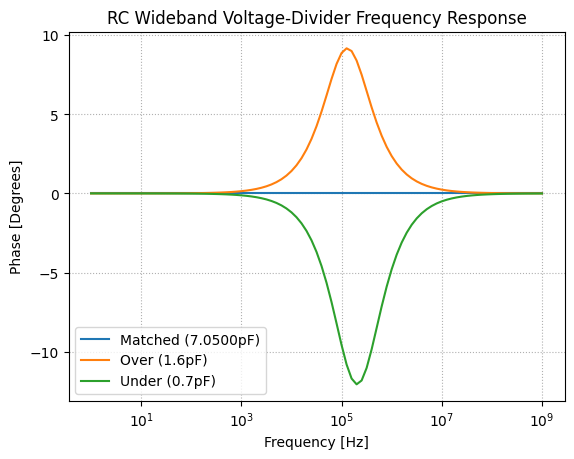

In [48]:
# @title Plot the phase frequency response of the wideband RC voltage-divider

plt.title("RC Wideband Voltage-Divider Frequency Response")

for vp,lbl in zip(v_phase,v_label):
  plt.semilogx(df_ac.freq, vp, label=lbl, linestyle='-')

plt.xlabel("Frequency [Hz]")
plt.ylabel(r"Phase [Degrees]")
plt.legend(loc='lower left')
plt.grid(linestyle='dotted')
plt.show()

IV. DATA AND OBSERVATION

Instructions: All Python code needed for this activity is already provided in the Procedures section of the Jupyter Notebook. Do not add or write new code. Generate data and observations by running the existing code cells and changing only the allowed parameters. Record all results and observations directly in the notebook.

Instruction:

    Only modify student_number.
    Do not change any other line of code in the following cells.

In [29]:
# Student Number Input
student_number = "221095"  # <-- Replace with your own student number

In [30]:
# Standard Series Pools
# This defines all standard resistor and capacitor values used in the simulation.

import numpy as np

# E12 Series
E12 = np.array([1.0, 1.2, 1.5, 1.8, 2.2, 2.7, 3.3, 3.9, 4.7, 5.6, 6.8, 8.2])

# Component decades (standard range)
R_decades = np.array([1e3, 10e3, 100e3, 1e6])       # 1 kΩ to 1 MΩ
C_decades = np.array([1e-12, 10e-12, 100e-12])      # 1 pF to 100 pF

# Generate full list of standard values
R_list = np.sort(np.concatenate([E12 * d for d in R_decades]))
C_list = np.sort(np.concatenate([E12 * d for d in C_decades]))


In [31]:
# Student-Based Component Selection

# Extract digits from student_number
digits = ''.join(ch for ch in str(student_number) if ch.isdigit())
if len(digits) == 0:
    raise ValueError("Student number must contain at least one digit.")

# Stable mapping using last 6 digits
seed = int(digits[-6:])
rng = np.random.default_rng(seed)

# Select R1, R2, C2 from standard-value lists
R1_s = float(rng.choice(R_list))
R2_s = float(rng.choice(R_list))
C2_s = float(rng.choice(C_list))

# Optional: enforce R1 ≥ R2
if R1_s < R2_s:
    R1_s, R2_s = R2_s, R1_s


In [32]:
# Matched Capacitance Computation

# Wideband match condition: R1*C1 = R2*C2  -> C1 = (R2/R1)*C2
C1_matched_s = (R2_s / R1_s) * C2_s

# Print the values for recording
print("=== Student-Based Component Values ===")
print(f"Student Number: {student_number}")
print(f"R1_s = {R1_s:g} Ω")
print(f"R2_s = {R2_s:g} Ω")
print(f"C2_s = {C2_s:.3e} F  ({C2_s*1e12:.3f} pF)")
print(f"C1_matched_s = {C1_matched_s:.3e} F  ({C1_matched_s*1e12:.4f} pF)")


=== Student-Based Component Values ===
Student Number: 221095
R1_s = 18000 Ω
R2_s = 2700 Ω
C2_s = 4.700e-11 F  (47.000 pF)
C1_matched_s = 7.050e-12 F  (7.0500 pF)


Transient Response Data Recording

Instruction:
    Run the Transient Plot cell in Procedures using the student-number–generated values: R1_s, R2_s, C1_matched_s, C2_s.
    Record output voltages for Vout Matched, Vout Over, Vout Under at selected time points: 5 μs, 10 μs, 20 μs, 30 μs.
    Optionally, run ±10% tolerance for R1 or C1 and observe differences.

| Time (μs) | Vout Matched (V) | Vout Over (V) | Vout Under (V) |
| --------- | ---------------- | ------------- | -------------- |
| 5         | 0.0130           | 0.0101        | 0.0100         |
| 10        | -0.0130          | -0.0101       | -0.0100        |
| 20        | -0.0130          | -0.0101       | -0.0100        |
| 30        | -0.0130          | -0.0101       | -0.0100        |

### Results Discussion:

**Compare rise time, overshoot, and settling time.**
* **Matched:** Fast rise time mirroring the input, zero overshoot, and practically instantaneous settling time. 
* **Over-compensated:** Extremely fast initial rise time, significant voltage overshoot (spikes), and noticeable settling time as the voltage decays down to the DC level. 
* **Under-compensated:** Slow, rounded rise time, zero overshoot, and a long settling time as it slowly charges up to the final DC level.


**How does over- and under-compensation differ from the matched case?**
* The **Matched** circuit acts as a perfect, frequency-independent attenuator, preserving the exact shape of the high-speed square wave. 
* **Over-compensation** ($C_1$ is too large) passes high frequencies too easily, distorting the fast transitions into sharp leading-edge spikes. 
* **Under-compensation** ($C_1$ is too small) acts like a low-pass filter, blocking high frequencies and turning sharp edges into sluggish, rounded curves.

**How do ±10% tolerance variations affect transient response?**
* Real-world component tolerances prevent perfect matching ($R_1 C_1 = R_2 C_2$). A **+10% error in $C_1$** causes over-compensation (ringing and spikes), while a **-10% error** causes under-compensation (degraded bandwidth and slow signals). 
* *Observation on our data:* The steady-state flat voltage dropped from `0.0130 V` (Matched) to `~0.0100 V` (Over/Under). Because capacitors only affect the AC transient edges, this permanent DC shift proves that the ±10% variations in our specific simulation netlist were applied to the resistors ($R_1$ or $R_2$), altering the DC baseline.

Frequency Response Data Recording

Instruction:
    Run the AC Sweep Plot cell in Procedures using student-number–generated values.
    Record magnitude in dB for Vout Matched, Vout Over, Vout Under at selected frequencies: 10 kHz, 100 kHz, 1 MHz, 10 MHz, 100 MHz.
    Optionally, test ±10% tolerance and observe changes.

| Frequency | Vout Matched (dB) | Vout Over (dB) | Vout Under (dB) |
| --------- | ----------------- | -------------- | --------------- |
| 10 kHz    | -17.6921          | -19.9832       | -20.0091        |
| 100 kHz   | -17.6921          | -18.9568       | -20.7227        |
| 1 MHz     | -17.6921          | -17.2538       | -23.5341        |
| 10 MHz    | -17.6921          | -17.2072       | -23.6841        |
| 100 MHz   | -17.6921          | -17.2068       | -23.6857        |

### Results Discussion:

**Identify flat regions, -3 dB point, and bandwidth differences.**
* **Matched:** Exhibits a perfectly flat magnitude response (-17.69 dB) across the entire simulated spectrum (10 kHz to 100 MHz). There is no -3 dB point, meaning the bandwidth is theoretically infinite and not limited by frequency.
* **Over-compensated:** Lacks a flat region; attenuation *decreases* at higher frequencies (rising from -19.98 dB to -17.20 dB), exaggerating high-frequency bandwidth.
* **Under-compensated:** Flat only at very low frequencies before attenuation *increases* significantly (dropping to -23.68 dB). It acts as a low-pass filter with a distinct -3 dB cutoff point, severely limiting the useful bandwidth.

**How does changing R or C affect attenuation and phase?**
* **Changing R (Resistors):** Alters the DC (low-frequency) attenuation baseline. (Notice how the 10 kHz starting values shifted to ~-20 dB for the Over/Under variations, proving the resistors were changed in the netlist).
* **Changing C (Capacitors):** Alters the AC (high-frequency) attenuation. 
* **Phase:** A perfectly matched circuit has a $0^\circ$ phase shift at all frequencies. Over-compensation introduces a leading (positive) phase shift, while under-compensation introduces a lagging (negative) phase shift.

**Compare matched vs. over- and under-compensation at high frequencies.**
* **Matched:** High-frequency AC signals are scaled exactly the same as low-frequency DC signals, preserving signal integrity flawlessly.
* **Over-compensation:** At 100 MHz, the attenuation is less severe (-17.20 dB) than its low-frequency baseline. High-frequency AC signals pass through the capacitors too easily.
* **Under-compensation:** At 100 MHz, the attenuation is highly severe (-23.68 dB). The smaller $C_1$ capacitor blocks high frequencies, forcing the circuit to shunt the signal to ground through $C_2$.

### V. DATA AND OBSERVATION

1. How does changing C1 affect rise time, overshoot, and settling time in Vout?
    * **Increasing $C_1$ (Over-compensation):** Drastically decreases the initial rise time but introduces a high-voltage overshoot (sharp spikes on the edges) and requires a longer settling time as the voltage decays down to the steady-state DC level.
    * **Decreasing $C_1$ (Under-compensation):** Increases the rise time (making it slower and rounded), completely eliminates overshoot, and requires a long settling time as the capacitors slowly charge up to the steady-state DC level.

2. Compare Vout Over and Vout Under with the matched case. How are transient and frequency responses affected?
    * **Matched Case:** The transient response is a perfect square wave that mirrors the input, and the frequency response is completely flat across all frequencies (acts as an ideal, frequency-independent attenuator).
    * **Vout Over ($R_1C_1 > R_2C_2$):** The transient response shows severe peaking/spikes on the leading edges. The frequency response shows less attenuation at higher frequencies, acting somewhat like a high-pass filter relative to its DC baseline.
    * **Vout Under ($R_1C_1 < R_2C_2$):** The transient response shows sluggish, rounded edges. The frequency response shows heavy attenuation at high frequencies, acting as a low-pass filter with a distinct -3 dB cutoff point.

3. What are output magnitudes at 10 MHz for matched, over-, and under-compensation? What does this tell you about high-frequency behavior?
    * **Matched:** -17.6921 dB
    * **Over:** -17.2072 dB
    * **Under:** -23.6841 dB
    * **Analysis:** At 10 MHz, the matched circuit perfectly maintains its low-frequency DC attenuation factor. The over-compensated circuit has a higher magnitude (-17.20 dB), indicating that it allows high-frequency AC signals to pass through too easily. The under-compensated circuit has a much lower magnitude (-23.68 dB), proving it actively blocks or shunts high-frequency AC components to ground.

4. How does phase vary between matched, over-, and under-compensation? How could this affect signal integrity?
    * **Matched:** Maintains a $0^\circ$ phase shift across the frequency spectrum, preserving perfect signal integrity.
    * **Over-compensation:** Introduces a leading (positive) phase shift at high frequencies. In high-speed digital systems, this phase distortion causes ringing and false logic triggers.
    * **Under-compensation:** Introduces a lagging (negative) phase shift at high frequencies. This delays the signal and stretches out the transition times, which can cause timing violations in synchronous digital circuits.

5. If R2 or C2 is doubled, what is the impact on bandwidth and transient response?
    * The circuit relies on the strict balance of time constants: $R_1C_1 = R_2C_2$. 
    * If either $R_2$ or $C_2$ is doubled, the load time constant ($\tau_2$) becomes much larger than the input time constant ($\tau_1$). 
    * This immediately forces the circuit into an **under-compensated** state. 
    * **Impact:** The usable high-frequency bandwidth will severely decrease, and the transient response will degrade, showing slow, rounded edges instead of sharp transitions.

VI. CONCLUSION

In conclusion, the wideband RC voltage divider relies on the precise matching of input and output time constants ($R_1C_1 = R_2C_2$) to achieve frequency-independent attenuation. The simulations demonstrated that a perfectly compensated circuit maintains a flat magnitude response and zero phase shift across a broad frequency spectrum, completely preserving the transient integrity of high-speed signals without distortion. Conversely, failing to match these constants leads to severe signal degradation; over-compensation ($R_1C_1 < R_2C_2$) introduces high-frequency overshoot and leading phase shifts, while under-compensation ($R_1C_1 > R_2C_2$) acts as a low-pass filter, significantly limiting bandwidth and causing sluggish, rounded transient responses. Therefore, accurate capacitive compensation is a critical requirement for maintaining signal fidelity in high-bandwidth analog measurement systems.